# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [27]:
# Install TensorFlow with GPU support and other dependencies
%pip install -q tensorflow[and-cuda] tensorflow-io[tensorflow] matplotlib kagglehub kaggle



zsh:1: no matches found: tensorflow[and-cuda]
Note: you may need to restart the kernel to use updated packages.


## 1.2 Load Dependencies

In [28]:
import os

# Authenticate with Kaggle using API credentials
kaggle_json_path = os.path.expanduser("kaggle.json")

# Get dirname of the kaggle.json file
kaggle_json_dir = os.path.dirname(kaggle_json_path)
# Check if the kaggle.json file exists
if not os.path.exists(kaggle_json_path):
    # If it doesn't exist, create the directory
    os.makedirs(kaggle_json_dir, exist_ok=True)
    # Create an empty kaggle.json file
    with open(kaggle_json_path, "w") as f:
        f.write("{}")
    print(f"kaggle.json file created at {kaggle_json_path}. Please add your Kaggle API credentials to this file.")
else:
    print(f"Kaggle API key found at {kaggle_json_path}")

# Set the KAGGLE_CONFIG_DIR environment variable to the directory containing kaggle.json
print (f"Setting KAGGLE_CONFIG_DIR to {kaggle_json_dir}")
os.environ["KAGGLE_CONFIG_DIR"] = kaggle_json_dir


# Set the environment variable
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
# Set the environment variable to use CPU cause My GPU cannot handle this
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio



import kagglehub
import kaggle

# # Import the Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
# # Authenticate using Kaggle API
api.authenticate()


# # Download the private dataset from Kaggle
# # This dataset contains audio files for chainsaw and non-chainsaw sounds
# # Note: To use Kaggle API, you need to set up your Kaggle API credentials.
# #* 1. Go to your Kaggle account settings: https://www.kaggle.com/account
# #* 2. Scroll down to the "API" section and click on "Create New API Token".
# #* 3. This will download a file named `kaggle.json`.
# #* 4. Place this file in the `~/.kaggle/` directory (Linux/Mac) or `%USERPROFILE%\.kaggle\` (Windows).
# #* 5. Ensure the file has proper permissions (e.g., `chmod 600 ~/.kaggle/kaggle.json` on Linux/Mac).


parsed_chainsaw_db = kagglehub.dataset_download("kennethalampay/chainsaw")

#? Sets the path to the dataset directory
PARSED_CHAINSAW_DIR = parsed_chainsaw_db  
print(f"Path to dataset files {PARSED_CHAINSAW_DIR}/")




Kaggle API key found at kaggle.json
Setting KAGGLE_CONFIG_DIR to 


Path to dataset files /home/khing/.cache/kagglehub/datasets/kennethalampay/chainsaw/versions/1/


In [29]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# gpus

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
#     print(f"GPU {gpu} is set to allow memory growth.")


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [30]:


CHAINSAW_FILE = os.path.join(PARSED_CHAINSAW_DIR, '2 (FULL).wav')
NOT_CHAINSAW_FILE = os.path.join('data', 'Parsed_Not_Chainsaw_Clips', 'afternoon-birds-song-in-forest-0.wav')

 # Verify that the files exist
assert os.path.exists(CHAINSAW_FILE), f"Chainsaw file not found: {CHAINSAW_FILE}"
assert os.path.exists(NOT_CHAINSAW_FILE), f"Not chainsaw file not found: {NOT_CHAINSAW_FILE}"

## 2.2 Build Dataloading Function

In [31]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [32]:
wave = load_wav_16k_mono(CHAINSAW_FILE)
nwave = load_wav_16k_mono(NOT_CHAINSAW_FILE)


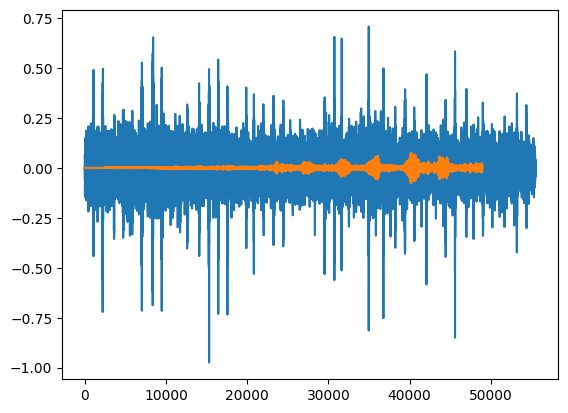

In [33]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [34]:
POS = os.path.join('data', 'Parsed_Chainsaw_Clips')
NEG = os.path.join('data', 'Parsed_Not_Chainsaw_Clips')


if not os.path.exists(POS):
    raise FileNotFoundError(f"Positive data path {POS} does not exist.")
if not os.path.exists(NEG):
    raise FileNotFoundError(f"Negative data path {NEG} does not exist.")


## 3.2 Create Tensorflow Datasets

In [35]:
pos = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))



## 3.3 Add labels and Combine Positive and Negative Samples

In [36]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)


# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [37]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Chainsaw_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Chainsaw_Clips', file))
    lengths.append(len(tensor_wave))


## 4.2 Calculate Mean, Min and Max

In [38]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=53722>

In [39]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=51743>

In [40]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=57387>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [41]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


## 5.2 Test Out the Function and Viz the Spectrogram

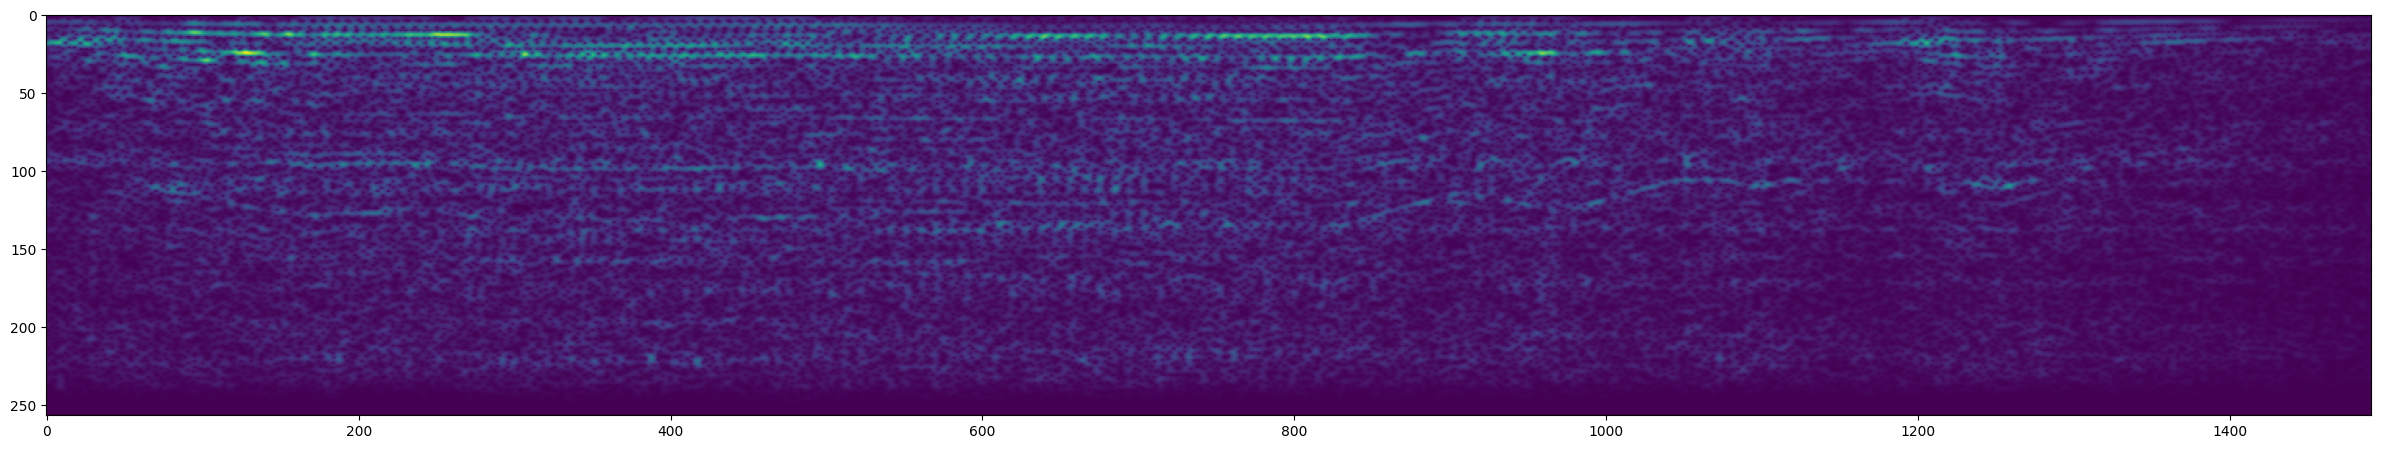

In [42]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()


# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [43]:
# Old
# data = data.map(preprocess)
# data = data.cache()
# data = data.shuffle(buffer_size=1000)
# data = data.batch(16)
# data = data.prefetch(8)

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16).map(lambda x, y: (tf.ensure_shape(x, (None, 1491, 257, 1)), y))  
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [44]:
train = data.take(36)
test = data.skip(36).take(15)

train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## 6.3 Test One Batch

In [45]:
samples, labels = train.as_numpy_iterator().next()

2025-04-03 14:20:15.718052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 85 of 1000
2025-04-03 14:20:35.807977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 252 of 1000
2025-04-03 14:20:55.823402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 423 of 1000
2025-04-03 14:21:05.840155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 505 of 1000
2025-04-03 14:21:25.547489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [46]:
samples.shape
# labels


(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [47]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense


## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
MODEL_PATH = 'model'

# make a flag MODEL_EXIST and check if if teh model already exsist  

MODEL_EXIST=False
# check the model file path  if it exist  hen true 
if os.path.exists(MODEL_PATH):
    print(f"Model already exists at {MODEL_PATH}")
if os.path.exist(os.path.join(MODEL_PATH, 'chainsaw_model.keras')):
    print(f"Model already exists at {MODEL_PATH}")
    MODEL_EXIST=True

# if model not exist then create a new model
if not MODEL_EXIST:
    print(f"Creating a new model at {MODEL_PATH}")
    # Create a new model
    model = Sequential()
    model.add(Input(shape=(1491, 257, 1)))  # Input layer
    model.add(Conv2D(16, (3, 3), activation='relu'))  # First Conv2D layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  # First MaxPooling layer
    model.add(Conv2D(16, (3, 3), activation='relu'))  # Second Conv2D layer
    model.add(Flatten())  # Flatten the feature maps
    model.add(Dense(128, activation='relu'))  # Fully connected layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer

IndentationError: expected an indented block after 'if' statement on line 9 (1877187216.py, line 12)

In [49]:
if not MODEL_EXIST:

    model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [50]:
if not MODEL_EXIST:
    model.summary()


## 7.3 Fit Model, View Loss and KPI Plots

In [51]:
# model.fit(train, epochs=4, validation_data=test)
if not MODEL_EXIST:
    hist = model.fit(train, epochs=4, validation_data=test)


## Save Model to:

1. Keras
2. H5
3. Onnx
4. Tensorflow SavedModel


In [54]:

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
# Save the model
if not MODEL_EXIST:
    #    Save Save the the model model in in the the recommended recommended `.keras` `
    model.save(os.path.join(MODEL_PATH, 'chainsaw_model.keras'))



In [55]:
# # Save the model in onnx format
# import tensorflow_hub as hub
# import tensorflowjs as tfjs
# import onnx
# import onnxruntime as ort
# import tf2onnx
# import tf2onnx.convert
# import tf2onnx.optimizer
# from tf2onnx import optimizer
# from tf2onnx import convert


# # Convert the model to ONNX format
# onnx_model = tf2onnx.convert.from_keras(model, output_path='model/chainsaw_model.onnx')
# # Save the ONNX model
# onnx.save_model(onnx_model, 'model/chainsaw_model.onnx')


if MODEL_EXIST:
    print(f"Model already exists at {MODEL_PATH}")
    # Load the model
    model = tf.keras.models.load_model('model/chainsaw_model.keras')



Model already exists at saved_model


ValueError: File not found: filepath=model/chainsaw_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
if not MODEL_EXIST:
    plt.title('Loss')
    plt.plot(hist.history['loss'], 'r')
    plt.plot(hist.history['val_loss'], 'b')
    plt.show()
    # 
    plt.title('Precision')
    plt.plot(hist.history['precision'], 'r')
    plt.plot(hist.history['val_precision'], 'b')
    plt.show()

    plt.title('Recall')
    plt.plot(hist.history['recall'], 'r')
    plt.plot(hist.history['val_recall'], 'b')
    plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Recordings', '(6) FINAL 3 MINS..mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Recordings')):
    FILEPATH = os.path.join('data','Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'chainsaw_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])